# GAN Generator for Face Animals

Dataset: https://www.kaggle.com/datasets/andrewmvd/animal-faces

In [7]:
 ! pip install -q kaggle

In [8]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lukaszkogut","key":"1af0534b12be108b204ce43b16e57203"}'}

In [9]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d 'andrewmvd/animal-faces'

100% 694M/696M [00:33<00:00, 23.7MB/s]
100% 696M/696M [00:33<00:00, 21.7MB/s]


In [13]:
import zipfile

!unzip animal-faces.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq

In [14]:

import torch
from torch import nn
from torchvision import datasets

from pathlib import Path

data_path = Path("afhq")

train_dir = data_path / "train"

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load Data

In [16]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(root=train_dir,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True)

In [22]:
img_batch, label_batch = next(iter(dataloader))

img_batch.shape

torch.Size([32, 3, 64, 64])

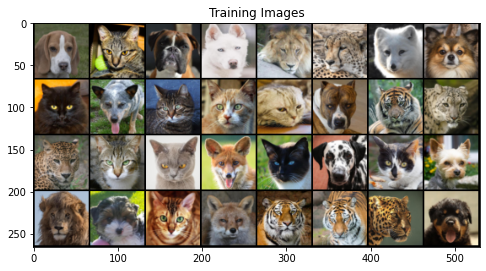

In [29]:
import matplotlib.pyplot as plt
import torchvision.utils

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.title("Training Images")
plt.imshow(torch.permute(torchvision.utils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

gen_input = 100
gen_features = 64
input_shape = 3
dis_features = 64

#Generator

In [31]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( gen_input, gen_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_features * 8, gen_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_features * 4, gen_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_features * 2, gen_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_features, input_shape, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
netG = Generator(1).to(device)
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [33]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(input_shape, dis_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_features, dis_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_features * 2, dis_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_features * 4, dis_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [35]:
netD = Discriminator(1).to(device)

In [36]:
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [37]:
from torch.optim import Adam

loss_fn = nn.BCELoss()

fixed_noise = torch.randn(64, gen_input, 1, 1, device=device)

real_label = 1.
fake_label = 0.

beta1 = 0.5

optimizerD = Adam(netD.parameters(), lr=0.0002, betas=(beta1, 0.999))
optimizerG = Adam(netG.parameters(), lr=0.0002, betas=(beta1, 0.999))

In [38]:
img_list = []
G_losses = []
D_losses = []
iters = 0

#Train

In [40]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = loss_fn(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, gen_input, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = loss_fn(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  

        output = netD(fake).view(-1)
        errG = loss_fn(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/458]	Loss_D: 1.1652	Loss_G: 4.9049	D(x): 0.5817	D(G(z)): 0.2792 / 0.0083
[0/5][50/458]	Loss_D: 0.1776	Loss_G: 8.8276	D(x): 0.9412	D(G(z)): 0.1041 / 0.0002
[0/5][100/458]	Loss_D: 0.6009	Loss_G: 7.1802	D(x): 0.9177	D(G(z)): 0.3310 / 0.0022
[0/5][150/458]	Loss_D: 0.2603	Loss_G: 4.2399	D(x): 0.9475	D(G(z)): 0.1727 / 0.0206
[0/5][200/458]	Loss_D: 0.5572	Loss_G: 7.1269	D(x): 0.8877	D(G(z)): 0.3107 / 0.0015
[0/5][250/458]	Loss_D: 0.5228	Loss_G: 3.8504	D(x): 0.6488	D(G(z)): 0.0107 / 0.0494
[0/5][300/458]	Loss_D: 0.2418	Loss_G: 6.1313	D(x): 0.8446	D(G(z)): 0.0260 / 0.0050
[0/5][350/458]	Loss_D: 0.9323	Loss_G: 5.8561	D(x): 0.8762	D(G(z)): 0.4296 / 0.0083
[0/5][400/458]	Loss_D: 0.2842	Loss_G: 3.7631	D(x): 0.8450	D(G(z)): 0.0667 / 0.0404
[0/5][450/458]	Loss_D: 1.1599	Loss_G: 4.1750	D(x): 0.5721	D(G(z)): 0.0490 / 0.0646
[1/5][0/458]	Loss_D: 1.3631	Loss_G: 6.9619	D(x): 0.9205	D(G(z)): 0.5788 / 0.0025
[1/5][50/458]	Loss_D: 0.3261	Loss_G: 6.0181	D(x): 0.8893	D(G(z)): 0.1331 / 0.0049
[1/5][100/

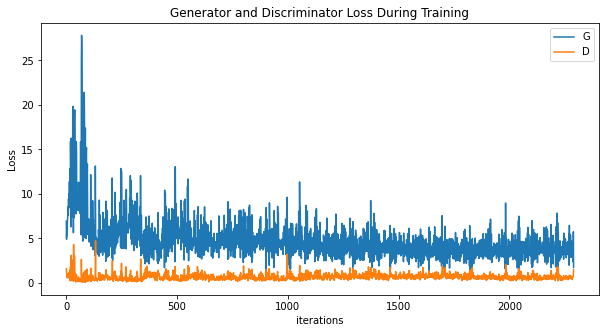

In [41]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[[<matplotlib.image.AxesImage at 0x7f0cf96e5490>],

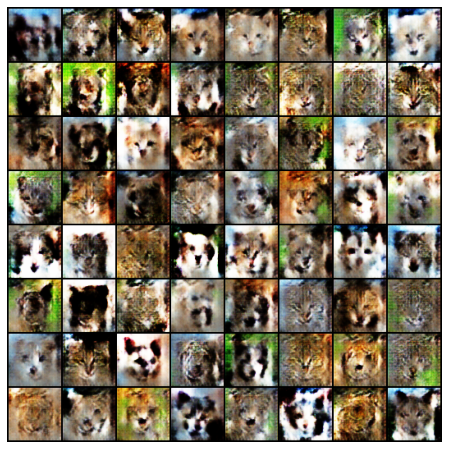

In [42]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(torch.permute(i,(1,2,0)), animated=True)] for i in img_list]

ims

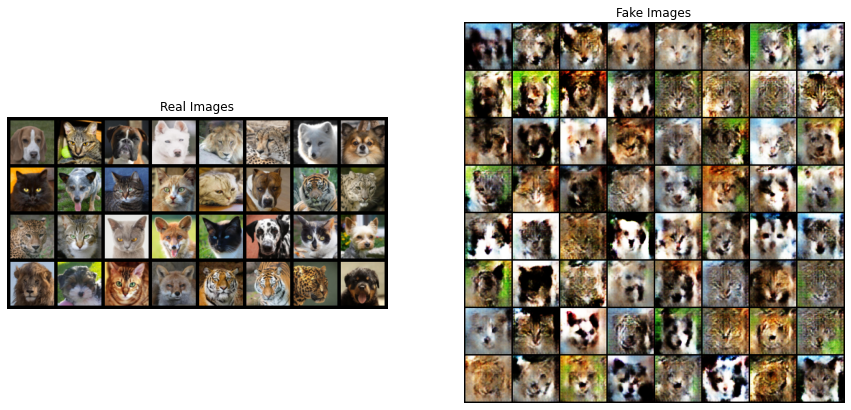

In [44]:
in_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(torch.permute(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(torch.permute(img_list[-1],(1,2,0)))
plt.show()

#Save Images

In [51]:
from torchvision.utils import save_image

i=0

for img in img_list:
  save_image(img, f"anim{i}.png")
  i+=1